# Proyek Klasifikasi Gambar Bahan Makanan

## Menyiapkan Library

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib


2024-01-16 03:06:05.266213: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 03:06:05.351716: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 03:06:05.351953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 03:06:05.353504: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 03:06:05.363783: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 03:06:05.364566: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Preprocessing Data

In [2]:
TRAINING_DIR = "dataset_1/train"
VALIDATION_DIR = "dataset_1/test"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    #horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))


Found 550 images belonging to 5 classes.


In [3]:
validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                            batch_size=16,
                                                            class_mode='categorical',
                                                            target_size=(150, 150))


Found 122 images belonging to 5 classes.


## Membuat Model

In [4]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output


2024-01-16 03:19:05.678489: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-16 03:19:05.679851: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


9406464/9406464 [==============================] - 1s 0us/step


In [5]:
x = tf.keras.layers.Flatten(name="flatten")(last_output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']        

In [6]:
int_lr = 1e-4
num_epochs = 30

optimizer = tf.optimizers.Adam(lr=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


## Melatih Model

In [7]:
H = model.fit(train_generator,
              epochs=num_epochs,
              validation_data=validation_generator)


Epoch 1/30
18/18 [==============================] - 11s 508ms/step - loss: 1.8507 - accuracy: 0.2673 - val_loss: 1.4373 - val_accuracy: 0.2951
Epoch 2/30
18/18 [==============================] - 8s 458ms/step - loss: 1.4320 - accuracy: 0.3909 - val_loss: 1.3210 - val_accuracy: 0.4836
Epoch 3/30
18/18 [==============================] - 8s 455ms/step - loss: 1.2004 - accuracy: 0.5073 - val_loss: 1.1928 - val_accuracy: 0.5410
Epoch 4/30
18/18 [==============================] - 8s 485ms/step - loss: 1.0787 - accuracy: 0.5236 - val_loss: 1.0986 - val_accuracy: 0.6967
Epoch 5/30
18/18 [==============================] - 8s 446ms/step - loss: 0.8459 - accuracy: 0.7400 - val_loss: 0.9297 - val_accuracy: 0.8197
Epoch 6/30
18/18 [==============================] - 8s 454ms/step - loss: 0.7077 - accuracy: 0.8255 - val_loss: 0.9749 - val_accuracy: 0.8525
Epoch 7/30
18/18 [==============================] - 8s 436ms/step - loss: 0.6304 - accuracy: 0.8564 - val_loss: 0.7055 - val_accuracy: 0.8852
Epoch

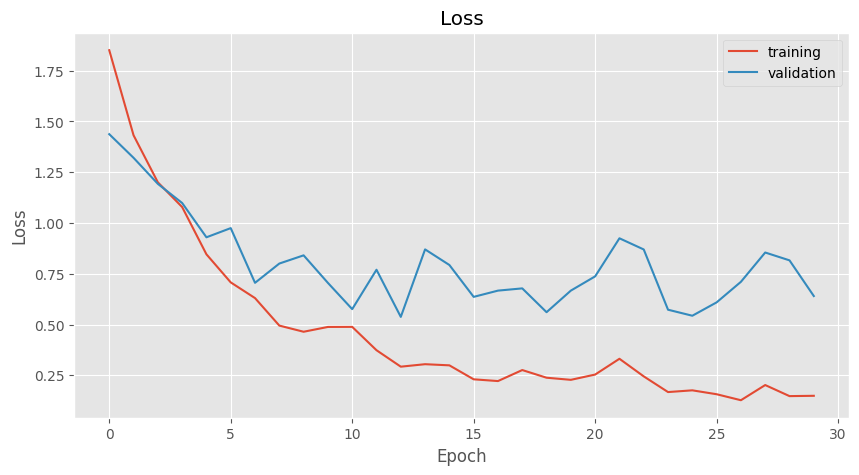

In [8]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["loss"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


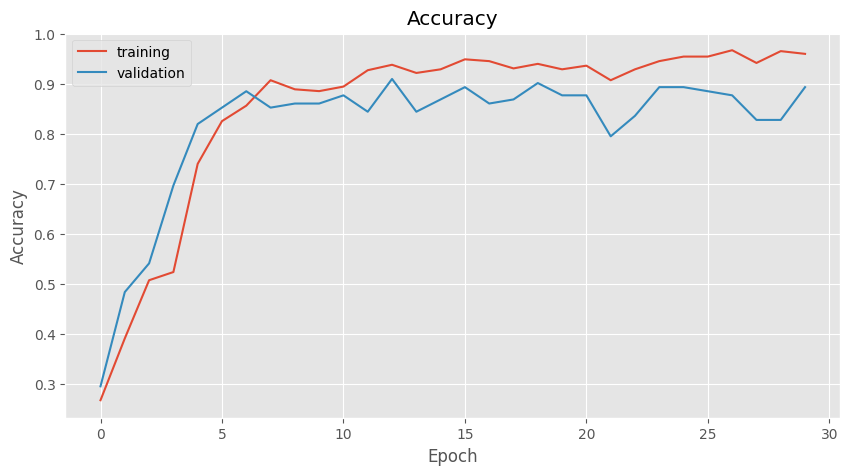

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()


## Mengubah Model

In [10]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [11]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()


2024-01-16 03:25:59.617827: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-16 03:25:59.617858: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-16 03:25:59.622250: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model/
2024-01-16 03:25:59.643374: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-16 03:25:59.643414: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: saved_model/
2024-01-16 03:25:59.699714: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-16 03:25:59.720424: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-16 03:26:00.256949: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: saved_model/
2024-01-16 03:26:00

In [12]:
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)


12999388